### Importing libraries

In [37]:
import openpyxl as op
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
import numpy as np
import pandas as pd
from openpyxl import Workbook
import re
from IPython.display import set_matplotlib_formats
from matplotlib.patches import Patch, PathPatch
import collections
import plotly.graph_objects as go
import os
import glob
import plotly.express as px
import statistics
from enum import auto

### Loading affected protein block summary table

In [ ]:
# GENCODE toy
pblocks = pd.read_csv('../B_hybrid_aln_results_toy/pblocks.tsv', sep='\t')

In [38]:
# GENCODE v41
pblocks = pd.read_csv('../B_hybrid_aln_gencode_v41/pblocks.tsv', sep='\t')

In [ ]:
# WTC11
pblocks = pd.read_csv('../B_hybrid_aln_wtc11/pblocks.tsv', sep='\t')

In [39]:
class CTerminalChange():
    SPLICING = auto()
    FRAMESHIFT = auto()
    ALTERNATIVE_ORF = auto()
    UNKNOWN = auto()

class NTerminalChange():
    MUTUALLY_EXCLUSIVE = auto()
    DOWNSTREAM_SHARED = auto()
    UPSTREAM_SHARED = auto()
    MUTUALLY_SHARED = auto()
    ALTERNATIVE_ORF = auto()
    UNKNOWN = auto()

### Plot 1: 

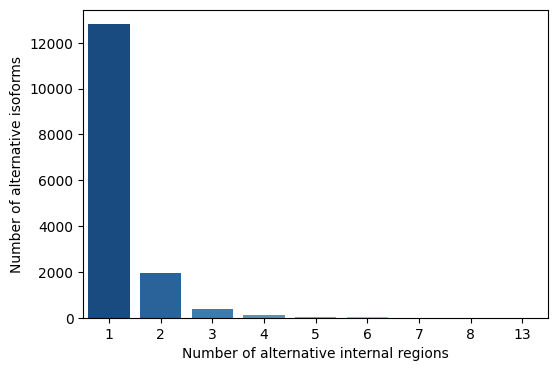

In [44]:
internal_pblocks = (
    pblocks[pblocks['nterm'].isna() & pblocks['cterm'].isna()].
    drop(columns=[col for col in pblocks.columns if 'start' in col or 'stop' in col]).
    copy()
)
internal_pblock_counts = internal_pblocks.groupby(['anchor', 'other']).agg(pblocks=('pblock_number', 'count'))

internal_pblock_counts_fig = plt.figure(figsize=(6, 4))
ax = sns.countplot(data=internal_pblock_counts, x='pblocks', palette='Blues_r')
ax.set(xlabel='Number of alternative internal regions', ylabel='Number of alternative isoforms')
plt.savefig('../F_internal_region_plots/internal-pblock-counts.svg', dpi=200, facecolor=None)

### Plot 2: 

In [37]:
internal_pblocks

,anchor,other,pblock_number,pblock_category,aa_loss,aa_gain,length_change,anchor_length,other_length,anchor_relative_length_change,...,internal,cblocks,tblocks,tblock_events,events,compound_splicing,frameshift,split_codons,anchor_seq,other_seq
0,A1CF-202,A1CF-201,0.0,DELETION,8.0,0.0,-8.0,595.0,587.0,-0.013445,...,True,"('DELETION',)","('DELETION',)","('a',)",frozenset({'a'}),False,False,False,EIYMNVPV,NaN
2,A1CF-202,A1CF-203,1.0,DELETION,8.0,0.0,-8.0,595.0,595.0,-0.013445,...,True,"('DELETION',)","('DELETION',)","('a',)",frozenset({'a'}),False,False,False,EIYMNVPV,NaN
3,A1CF-202,A1CF-204,0.0,DELETION,8.0,0.0,-8.0,595.0,587.0,-0.013445,...,True,"('DELETION',)","('DELETION',)","('a',)",frozenset({'a'}),False,False,False,EIYMNVPV,NaN
4,A1CF-202,A1CF-205,0.0,DELETION,8.0,0.0,-8.0,595.0,587.0,-0.013445,...,True,"('DELETION',)","('DELETION',)","('a',)",frozenset({'a'}),False,False,False,EIYMNVPV,NaN
7,A1CF-202,A1CF-207,1.0,DELETION,8.0,0.0,-8.0,595.0,595.0,-0.013445,...,True,"('DELETION',)","('DELETION',)","('a',)",frozenset({'a'}),False,False,False,EIYMNVPV,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57622,ZSWIM8-223,ZSWIM8-213,1.0,DELETION,9.0,1.0,-8.0,1838.0,1797.0,-0.004353,...,True,"('DELETION', 'EDGE')","('DELETION',)","('d',)",frozenset({'d'}),False,False,True,CELWGQGTV,L
57623,ZSWIM8-223,ZSWIM8-220,0.0,DELETION,182.0,0.0,-182.0,1838.0,1656.0,-0.099021,...,True,"('DELETION',)","('DELETION',)","('da',)","frozenset({'d', 'a'})",True,False,False,GGGVYPEVLFEVAHQWFWLYEQTAGGSSTAREGATSCSASGIRAGG...,NaN
57624,ZSWIM8-223,ZSWIM8-221,0.0,INSERTION,0.0,5.0,5.0,1838.0,1835.0,0.002720,...,True,"('INSERTION',)","('INSERTION',)","('A',)",frozenset({'A'}),False,False,False,NaN,VVSPT
57625,ZSWIM8-223,ZSWIM8-221,1.0,DELETION,9.0,1.0,-8.0,1838.0,1835.0,-0.004353,...,True,"('DELETION', 'EDGE')","('DELETION',)","('d',)",frozenset({'d'}),False,False,True,CELWGQGTV,L


In [45]:
internal_cat_palette = {'DELETION': '#f800c0', 'INSERTION': '#00c0f8', 'SUBSTITUTION': '#f8c000'}
internal_event_palette = {
    'Intron': '#e69138',
    'Alt. donor': '#6aa84f',
    'Alt. acceptor': '#8a4ea7',
    'Single exon': '#3d85c6',
    'Mutually exclusive exons': '#255179',
    'Compound': '#888888'
}

internal_subcats = pd.DataFrame(
    {
        'Intron': internal_pblocks['tblock_events'].isin({"('I',)", "('i',)"}),
        'Alt. donor': internal_pblocks['tblock_events'].isin({"('D',)", "('d',)"}),
        'Alt. acceptor': internal_pblocks['tblock_events'].isin({"('A',)", "('a',)"}),
        'Single exon': internal_pblocks['tblock_events'].isin({"('E',)", "('e',)"}),
        'Mutually exclusive exons': internal_pblocks['tblock_events'].isin({"('E', 'e')", "('e', 'E')"}),
        'Compound': [True for _ in internal_pblocks.index]
    }
)

internal_subcats

,Intron,Alt. donor,Alt. acceptor,Single exon,Mutually exclusive exons,Compound
0,False,False,True,False,False,True
2,False,False,True,False,False,True
3,False,False,True,False,False,True
4,False,False,True,False,False,True
7,False,False,True,False,False,True
...,...,...,...,...,...,...
57622,False,True,False,False,False,True
57623,False,False,False,False,False,True
57624,False,False,True,False,False,True
57625,False,True,False,False,False,True


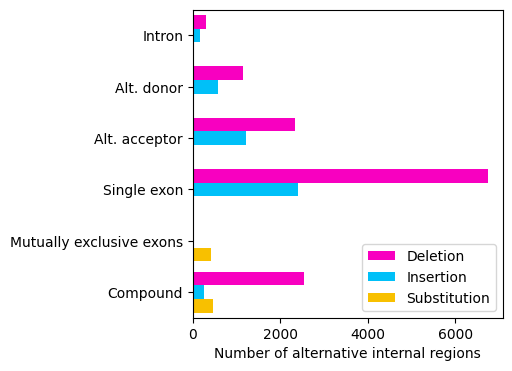

In [46]:
internal_pblocks['splice event'] = internal_subcats.idxmax(axis=1).astype(pd.CategoricalDtype(internal_subcats.columns, ordered=True))

internal_pblocks_fig = plt.figure(figsize=(4, 4))
ax = sns.countplot(
    data = internal_pblocks.sort_values('pblock_category', ascending=True),
    y = 'splice event',
    hue = 'pblock_category',
    palette = internal_cat_palette,
    saturation = 1,
    dodge = True,
)
plt.legend(loc='lower right', labels=['Deletion', 'Insertion', 'Substitution'])
ax.set(xlabel='Number of alternative internal regions', ylabel=None)
plt.savefig('../F_internal_region_plots/internal-pblock-events.svg', dpi=200, facecolor=None, bbox_inches='tight')

### Plot 3: 

In [43]:
internal_pblocks.sort_values('pblock_category', ascending=True)

,anchor,other,pblock_number,pblock_category,aa_loss,aa_gain,length_change,anchor_length,other_length,anchor_relative_length_change,...,internal,cblocks,tblocks,tblock_events,events,compound_splicing,frameshift,split_codons,anchor_seq,other_seq
0,A1CF-202,A1CF-201,0.0,DELETION,8.0,0.0,-8.0,595.0,587.0,-0.013445,...,True,"('DELETION',)","('DELETION',)","('a',)",frozenset({'a'}),False,False,False,EIYMNVPV,NaN
33625,NIBAN3-208,NIBAN3-207,0.0,DELETION,36.0,0.0,-36.0,621.0,585.0,-0.057971,...,True,"('DELETION',)","('DELETION',)","('e',)",frozenset({'e'}),False,False,False,KFKSDSGLAQRRFIRGWGLCIFLPFVLSQLEPGCKK,NaN
33627,NIBAN3-208,NIBAN3-211,0.0,DELETION,23.0,0.0,-23.0,621.0,570.0,-0.037037,...,True,"('DELETION',)","('DELETION',)","('d',)",frozenset({'d'}),False,False,False,VLRQISRELGPQEPTGSQLLRSK,NaN
33628,NIBAN3-208,NIBAN3-211,1.0,DELETION,28.0,0.0,-28.0,621.0,570.0,-0.045089,...,True,"('DELETION',)","('DELETION',)","('e',)",frozenset({'e'}),False,False,False,ELKKTLGANDVSCTLDGCLEVPWEQEGA,NaN
33630,NICN1-201,NICN1-204,0.0,DELETION,38.0,0.0,-38.0,214.0,176.0,-0.177570,...,True,"('DELETION',)","('DELETION',)","('e',)",frozenset({'e'}),False,False,False,MLCDMARISELRLILRQPSPLWLSFTVEELQIYQQGPK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9604,CEP41-201,CEP41-203,0.0,SUBSTITUTION,73.0,4.0,-69.0,374.0,305.0,-0.184492,...,True,"('INSERTION', 'DELETION', 'EDGE')","('INSERTION', 'DELETION')","('D', 'e')","frozenset({'e', 'D'})",True,False,True,GLKVLAQKFPEGLITGSLPASCQQALPPGSARKRSSPKGPPLPAEN...,GEQG
44233,SCN3A-201,SCN3A-202,0.0,SUBSTITUTION,32.0,32.0,0.0,2001.0,1952.0,0.000000,...,True,"('EDGE', 'INSERTION', 'DELETION', 'EDGE')","('INSERTION', 'DELETION')","('E', 'e')","frozenset({'E', 'e'})",True,False,True,AYVTEFVDLGNVSALRTFRVLRALKTISVIPG,AYVTEFVSLGNVSALRTFRVLRALKTISVIPG
5682,BIN1-209,BIN1-205,1.0,SUBSTITUTION,43.0,36.0,-7.0,483.0,507.0,-0.014493,...,True,"('DELETION', 'INSERTION')","('DELETION', 'INSERTION')","('e', 'E')","frozenset({'E', 'e'})",True,False,False,LRKGPPVPPPPKHTPSKEVKQEQILSLFEDTFVPEISVTTPSQ,PTESPAGSLPSGEPSAAEGTFAVSWPSQTAEPGPAQ
44245,SCN5A-202,SCN5A-203,0.0,SUBSTITUTION,32.0,32.0,0.0,2017.0,2017.0,0.000000,...,True,"('EDGE', 'INSERTION', 'DELETION', 'EDGE')","('INSERTION', 'DELETION')","('E', 'e')","frozenset({'E', 'e'})",True,False,True,AYTTEFVDLGNVSALRTFRVLRALKTISVISG,AYVSENIKLGNLSALRTFRVLRALKTISVIPG


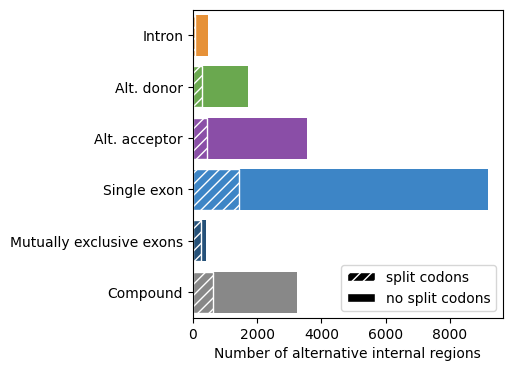

In [47]:

# %%
internal_pblocks_split_fig = plt.figure(figsize=(4, 4))
ax = sns.countplot(
    data = internal_pblocks.sort_values('pblock_category', ascending=True),
    y = 'splice event',
    palette = internal_event_palette,
    saturation = 1,
)
sns.countplot(
    ax = ax,
    data = internal_pblocks[internal_pblocks['split_codons']].sort_values('pblock_category', ascending=True),
    y = 'splice event',
    fill = False,
    edgecolor = 'w',
    hatch = '///',
)
plt.legend(loc='lower right', handles=[Patch(facecolor='k', edgecolor='w', hatch='///'), Patch(facecolor='k', edgecolor='w')], labels=['split codons', 'no split codons'])
ax.set(xlabel='Number of alternative internal regions', ylabel=None)
plt.savefig('../F_internal_region_plots/internal-pblock-events-split.svg', dpi=200, facecolor=None, bbox_inches='tight')

# %%


### Plot 4

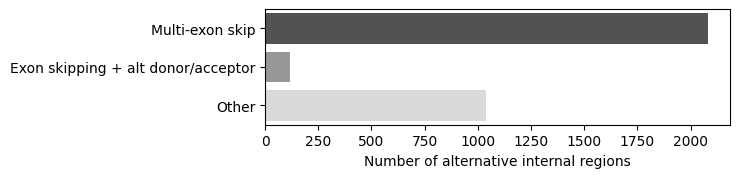

In [48]:
internal_compound_pblocks = internal_pblocks[internal_pblocks['splice event'] == 'Compound'].copy()

internal_compound_subcats = pd.DataFrame(
    {
        'Multi-exon skip': internal_compound_pblocks['events'] == f"{frozenset('e')}",
        'Exon skipping + alt donor/acceptor': internal_compound_pblocks['events'].isin({
            f"{frozenset('de')}",
            f"{frozenset('De')}",
            f"{frozenset('ea')}",
            f"{frozenset('eA')}",
            f"{frozenset('dea')}",
            f"{frozenset('Dea')}",
            f"{frozenset('deA')}",
            f"{frozenset('DeA')}",
        }),
        'Other': [True for _ in internal_compound_pblocks.index]
    }
)
internal_compound_pblocks['compound_subcat'] = internal_compound_subcats.idxmax(axis=1).astype(pd.CategoricalDtype(internal_compound_subcats.columns, ordered=True))

internal_pblocks_compound_fig = plt.figure(figsize=(6, 1.5))
ax = sns.countplot(
        data = internal_compound_pblocks,
        y = 'compound_subcat',
        palette = 'Greys_r',
        saturation = 1,
        linewidth = 0,
)
ax.set(xlabel='Number of alternative internal regions', ylabel=None)
plt.savefig('../F_internal_region_plots/internal-pblock-compound-events.svg', dpi=200, facecolor=None, bbox_inches='tight')